In [1]:
import os
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras import layers
from tensorflow import data as tf_data

Base de datos

El archivo kagglecatsanddogs_5340.zip contiene 25.000 imágenes de perros y gatos.

In [2]:
# Descargamos los datos en el almacenamiento temporal de Google Colab
#!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

#run unzip el conjunto de datos
#!unzip -q kagglecatsanddogs_5340.zip

In [3]:
# Visualiza la ruta y el pad de la base de datos.

#!ls
#!ls PetImages

In [4]:
# Elimina las imagenes que no estan en formato tipo JFIF

num_skipped = 0

for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


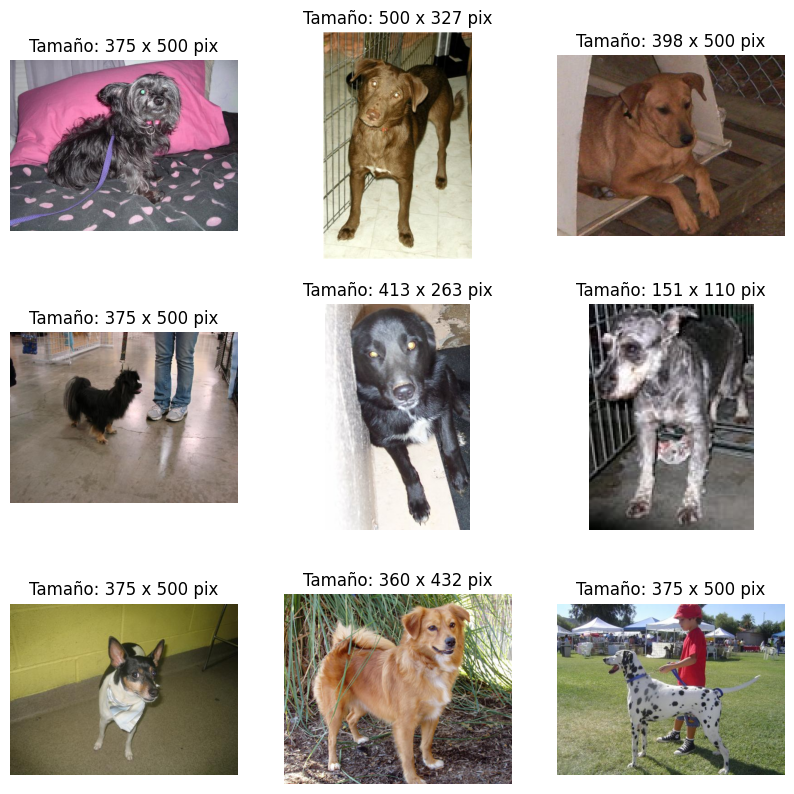

In [5]:
# Visualiza las primeras 9 imagenes de la carpeta "Dog"

plt.figure(figsize=(10, 10))

folder_path = os.path.join("PetImages", "Dog")
for i, image in enumerate(os.listdir(folder_path)[:9]):
  img_path = os.path.join(folder_path, image)
  img = mpimg.imread(img_path)
  ax = plt.subplot(3, 3, i + 1) # (nrows, ncols, index)
  plt.imshow(img)
  plt.title(f"Tamaño: {img.shape[:2][0]} x {img.shape[:2][1]} pix")
  plt.axis("off")

plt.show()

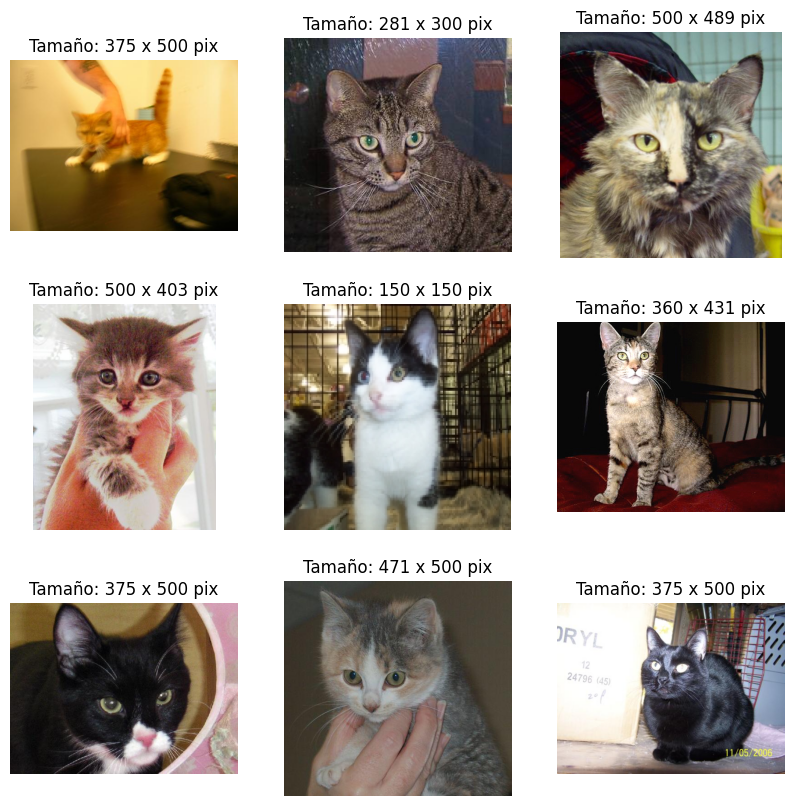

In [6]:
# Visualiza las primeras 9 imagenes de la carpeta "Cat"

plt.figure(figsize=(10, 10))

folder_path = os.path.join("PetImages", "Cat")
for i, image in enumerate(os.listdir(folder_path)[:9]):
  img_path = os.path.join(folder_path, image)
  img = mpimg.imread(img_path)
  ax = plt.subplot(3, 3, i + 1) # (nrows, ncols, index)
  plt.imshow(img)
  plt.title(f"Tamaño: {img.shape[:2][0]} x {img.shape[:2][1]} pix")
  plt.axis("off")

plt.show()

In [7]:
# Generando el conjunto de datos de entrenamiento
# La base de datos de imagenes tiene 23140 imagenes
# su divide la base de datos en 80% para entrenamiento (18728)
# su divide la base de datos en 20% para validacion    ( 4682)

# Se filtan las imagenes para estandarizar el tamaño.
# Con este tipo de metodo solo es posible procesar imagenes del mismo tamaño.

image_size = (180, 180)

# Tamaño del paquete del batch : Indica cuantas imagenes se van a procesar simultaneamente.

batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Using 4684 files for validation.


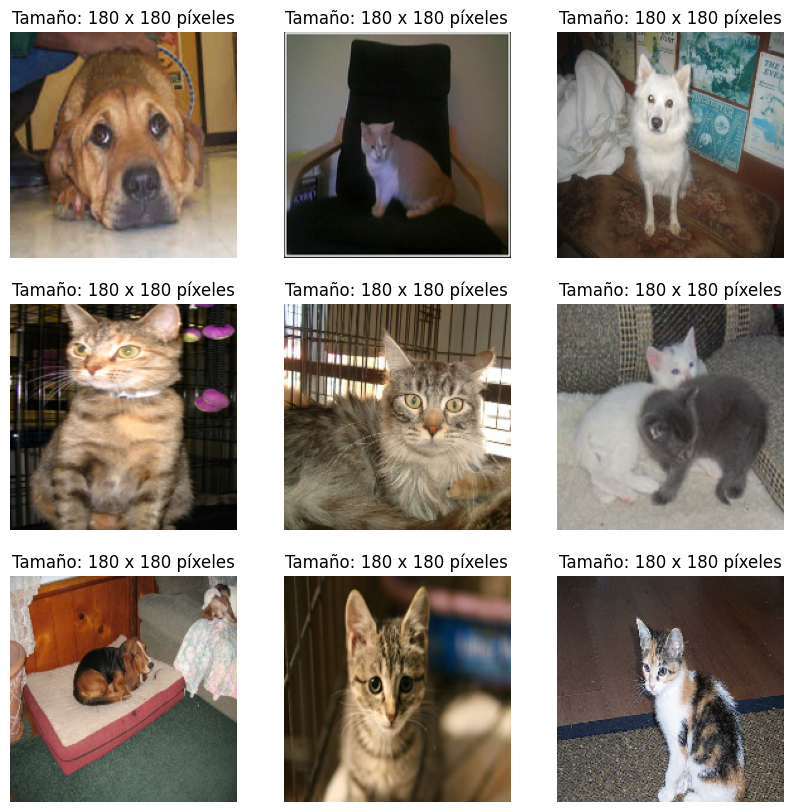

In [8]:
# Visualizacion de 9 archivos de la base de datos.

# train_ds.take(1) se obtiene un batc de 128 elementos.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(f"Tamaño: {images[i].shape[0]} x {images[i].shape[1]} píxeles")
        plt.axis("off")

In [9]:
# Conjunto de datos para la RNA
len(train_ds)

147

In [10]:
batch = list(train_ds.take(1))
print("Número de imágenes en el batch:", len(batch[0][0]))
print("Etiquetas del batch: ",batch[0][1])

Número de imágenes en el batch: 128
Etiquetas del batch:  tf.Tensor(
[0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 1 0 0 1 0
 0 1 0 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1
 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0
 1 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 0], shape=(128,), dtype=int32)


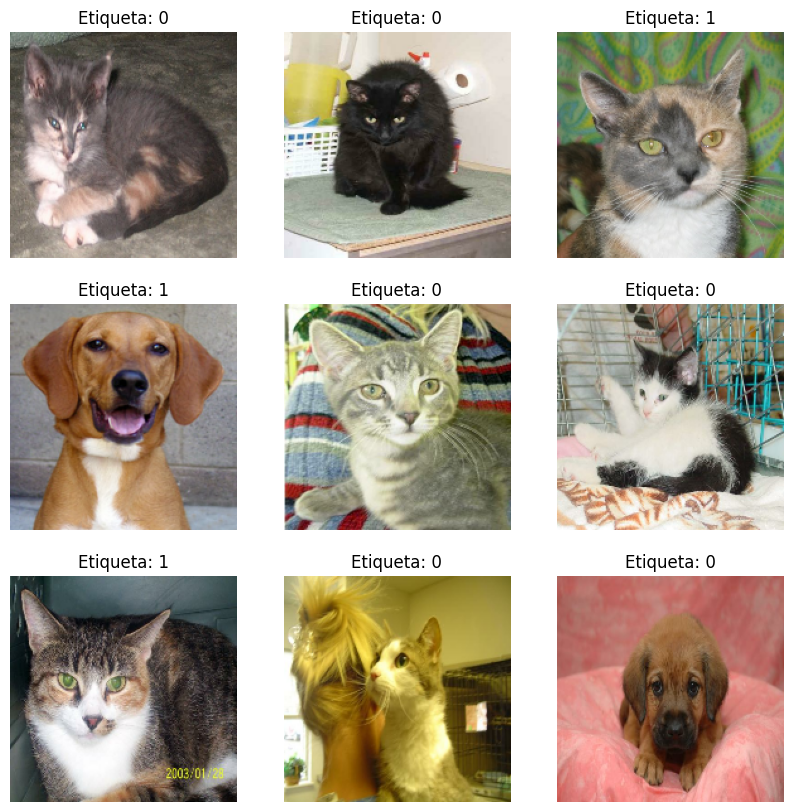

In [11]:
# Mostramos dos imágenes del batch con su etiqueta
plt.figure(figsize=(10, 10))

for img, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(f"Etiqueta: {labels[i]}")
    plt.axis("off")

plt.show()

Cuando abordamos la resolución de un problema real aplicando Inteligencia Artificial / Machine Learning / Deep Learning, debemos dividir el conjunto de datos en 3 subconjuntos:
* **Subconjunto de entrenamiento** (`train_ds`): Contiene apróximadamente el 60-80% de los datos. Este subcojunto se utiliza para entrenar el algoritmo.
* **Subconjunto de validación** (`val_ds`): Contiene apróximadamente el 10-20% de los datos. Este subcojunto se utiliza para validar el comportamiento del algoritmo durante el proceso de entrenamiento.
* **Subconjunto de pruebas** (`test_ds`): Contiene apróximadamente el 10-20% de los datos. Este subconjunto se utilizar para validar el comportamiento del algoritmo entrenado final. Su función es determinar si el modelo se comporta correctamente para ejemplos que no ha visto nunca.

Esta división y modo de actuar nos permite evitar problemas graves como el sobreentrenamiento u _overfitting_.

Keras nos permite dividir de manera muy sencilla el conjunto de datos en el subconjunto de entrenamiento y validación.

In [12]:
# Obtenemos el suconjunto de validación

temp_val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,  # 20% de los datos forman parte del subconjunto de validación
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


In [13]:
# Obtenemos el suconjunto de validación

print("batch total = ",len(temp_val_ds))

size = int(0.5 * len(temp_val_ds))
print("batch segmento = ",size)

val_ds = temp_val_ds.take(size) 
test_ds = temp_val_ds.skip(size) 

print("batch validacion = ",len(val_ds))
print("batch pruebas = ",len(test_ds))

batch total =  37
batch segmento =  18
batch validacion =  18
batch pruebas =  19


In [14]:
# train_test_split no puede trabajar con objetos Dataset de Tensorflow
# Esto supone un incremento del consumo de memoria RAM

# val_ds_sk = list(temp_val_ds)

# from sklearn.model_selection import train_test_split

# División del conjunto de validación en validación y prueba
# val_ds_sk, test_ds_sk = train_test_split(
#    val_ds_sk,
#    test_size=0.5,      # Porcentaje para prueba
#    random_state=42,    # Semilla para reproducibilidad
# )

# print("batch validacion = ",len(val_ds_sk))
# print("batch pruebas = ",len(test_ds_sk))


In [15]:

num_classes=2

# Dimension de las imagenes

input_shape = (180, 180, 3)
inputs = keras.Input(shape=input_shape)

# Entry block
x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

previous_block_activation = x  # Set aside residual

for size in [256, 512, 728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

x = layers.SeparableConv2D(1024, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.GlobalAveragePooling2D()(x)
if num_classes == 2:
    units = 1
else:
    units = num_classes

x = layers.Dropout(0.25)(x)
# We specify activation=None so as to return logits
outputs = layers.Dense(units, activation=None)(x)

model = keras.Model(inputs, outputs)


In [16]:
# Compilamos el modelo
model.compile(
    loss='binary_crossentropy', 
    optimizer=keras.optimizers.Adam(1e-3), 
    metrics=['accuracy']
    )

In [17]:
train_ds = train_ds.take(10)
val_ds = temp_val_ds.take(1) 
test_ds = temp_val_ds.skip(36) 

history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


10/10 ━━━━━━━━━━━━━━━━━━━━ 496s 46s/step - accuracy: 0.5363 - loss: 5.9527 - val_accuracy: 0.5078 - val_loss: 0.9792
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 511s 52s/step - accuracy: 0.4835 - loss: 7.7776 - val_accuracy: 0.5078 - val_loss: 0.8205
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 438s 45s/step - accuracy: 0.5240 - loss: 7.2467 - val_accuracy: 0.5000 - val_loss: 0.7042
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 524s 52s/step - accuracy: 0.4914 - loss: 7.7913 - val_accuracy: 0.4922 - val_loss: 0.7448
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 559s 58s/step - accuracy: 0.4924 - loss: 7.7075 - val_accuracy: 0.4922 - val_loss: 1.4916
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 790s 84s/step - accuracy: 0.5059 - loss: 7.6122 - val_accuracy: 0.4922 - val_loss: 8.0957
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 755s 73s/step - accuracy: 0.4657 - loss: 7.9267 - val_accuracy: 0.4922 - val_loss: 8.0957
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 653s 62s/step - accuracy: 0.4917 - loss: 7.6049 - val_accuracy: 0.4922 - val_

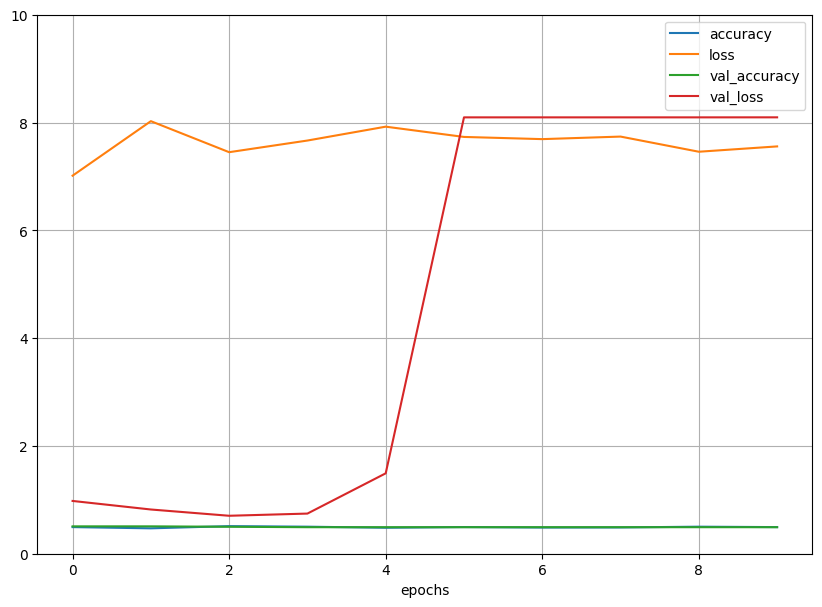

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 10)
plt.xlabel("epochs")
plt.show()

In [19]:
# Evaluamos el modelo con el conjunto de datos de pruebas
evaluation_result = model.evaluate(test_ds)

# Imprimir las métricas de evaluación (por ejemplo, pérdida y precisión)
print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.5132 - loss: 7.5945
Loss: 7.594529151916504
Accuracy: 0.5131579041481018


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step


C:\Users\josed\AppData\Local\Temp\ipykernel_15684\4199961380.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(predictions[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


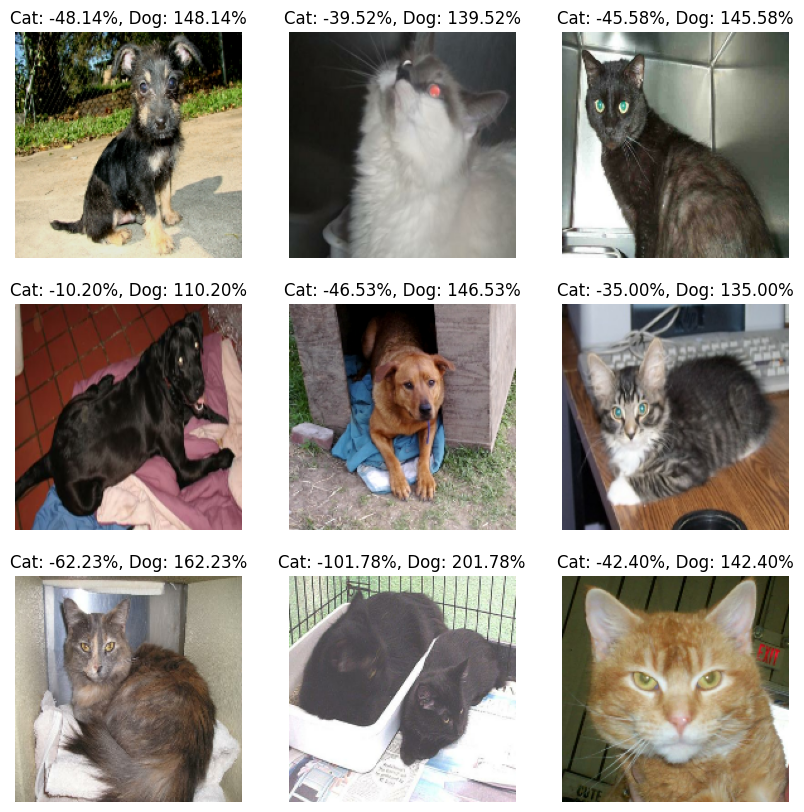

In [20]:
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1): # take(1) obtiene un lote del conjunto de datos (128 ejemplos)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = float(predictions[0])
        plt.title(f"Cat: {100 * (1 - score):.2f}%, Dog: {100 * score:.2f}%")
        plt.axis("off")

plt.show()